In [2]:
!pip install pydotplus

    100% |████████████████████████████████| 286kB 3.0MB/s 
  Running setup.py bdist_wheel for pydotplus ... - done
  Stored in directory: /content/.cache/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install graphviz

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
import pandas as pd
import numpy as np

import pydotplus
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


from IPython import display
from matplotlib import cm
from matplotlib import gridspec
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [0]:
df_hour = pd.read_csv("https://raw.githubusercontent.com/yezhilengyue/Python_ML_Practice/master/Project-%5BRegression%5Dbike-sharing/data/hour.csv")

In [0]:
df_hour.rename(
    columns = {
     'instant' : "record_id",
     'dteday' : "datetime",
     'holiday' : "is_holiday",
     'workingday' : "is_workingday",
     'weathersit' : "weather_condition",
     'hum' : "humidity",
     'mnth' : "month",
     'cnt' : "total_count",
     'hr' : "hour",
     'yr' : "year"},
    inplace = True )

df_hour['datetime'] = pd.to_datetime(df_hour.datetime)

df_hour['season'] = df_hour.season.astype('category')
df_hour['is_holiday'] = df_hour.is_holiday.astype('category')
df_hour['weekday'] = df_hour.weekday.astype('category')
df_hour['weather_condition'] = df_hour.weather_condition.astype('category')
df_hour['is_workingday'] = df_hour.is_workingday.astype('category')
df_hour['month'] = df_hour.month.astype('category')
df_hour['year'] = df_hour.year.astype('category')
df_hour['hour'] = df_hour.hour.astype('category')

In [0]:
df_hour = df_hour.reindex(np.random.permutation(df_hour.index))

In [0]:
def preprocess_features(df_hour):
    
    # 	longitude	latitude	housing_median_age	total_rooms	total_bedrooms	population	households	median_income	median_house_value
    selected_features = df_hour[[
 'record_id',
 'datetime',
 'season',
 'year',
 'month',
 'hour',
 'is_holiday',
 'weekday',
 'is_workingday',
 'weather_condition',
 'temp',
 'atemp',
 'humidity',
 'windspeed']]
    
    processed_features = selected_features.copy()
    #processed_features["rooms_per_person"] = california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"]
    
    return processed_features

def preprocess_targets(df_hour):
    
    output_targets = pd.DataFrame()
    output_targets['total_count'] = df_hour['total_count']
    return output_targets

In [11]:
# Choose the first 11470 (out of 17379) examples for training.
training_examples = preprocess_features(df_hour.head(11470))
training_targets = preprocess_targets(df_hour.head(11470))

validation_examples = preprocess_features(df_hour.tail(5909))
validation_targets = preprocess_targets(df_hour.tail(5909))

print("Training set::{}{}".format(training_examples.shape, training_targets.shape))
print("Validation set::{}".format(validation_examples.shape))

Training set::(11470, 14)(11470, 1)
Validation set::(5909, 14)


In [12]:
training_examples.reset_index(inplace = True)
training_targets = training_targets.reset_index()

validation_examples.reset_index(inplace = True)
validation_targets = validation_targets.reset_index()

print("Training set::{}{}".format(training_examples.shape, training_targets.shape))
print("Validation set::{}".format(validation_examples.shape))

Training set::(11470, 15)(11470, 2)
Validation set::(5909, 15)


In [0]:
numeric_feature_cols = ['temp','humidity','windspeed',
                        'hour','weekday','month','year']
subset_cat_features =  ['season','is_holiday',
                        'weather_condition','is_workingday']
# cat_attr_list = ['season', 'is_holiday',
#                  'weather_condition','is_workingday',
#                  'hour','weekday',
#                  'month','year']

In [0]:
def create_training_input_fn(df,col_name):
    """This function performs one hot encoding for the specified
        column.
    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        col_name: the column to be one hot encoded
    Returns:
        tuple: label_encoder, one_hot_encoder, transformed column as pandas Series
    """
    # label-encode feature (integer encoded)
    label_encoders = preprocessing.LabelEncoder()
    integer_encoded = label_encoders.fit_transform(df[col_name])
    
    # make one hot encoding (binary encoded)
    onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    
    feature_arr = onehot_encoder.fit_transform(integer_encoded)
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in label_encoders.classes_]
    feature_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return label_encoders, onehot_encoder, feature_df

In [0]:
def create_predict_input_fn(df, col_name, label_encoders, onehot_encoder):
    
    # find the encoded label
    col_labels = label_encoders.transform(df[col_name])
    
    # make one hot encoding
    col_labels = col_labels.reshape(len(col_labels), 1)
    
    feature_arr = onehot_encoder.fit_transform(col_labels)
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in label_encoders.classes_]
    feature_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return feature_df

In [0]:
# category_feature_encoded_list = []

# for col in subset_cat_features:
#     return_obj = create_training_input_fn(training_examples, col)
#     category_feature_encoded_list.append({'label_enc':return_obj[0],
#                                           'ohe_enc':return_obj[1],
#                                           'feature_df':return_obj[2],
#                                           'col_name':col})

training_encoded_category_features = []

for col in subset_cat_features:
    return_obj = create_training_input_fn(training_examples, col)
    training_encoded_category_features.append({'label_enc':return_obj[0],
                                               'ohe_enc':return_obj[1],
                                               'feature_df':return_obj[2],
                                               'col_name':col})

In [18]:
feature_df_list = [training_examples[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] for enc in category_feature_encoded_list])

training_input_fn = pd.concat(feature_df_list, axis=1)
training_targets = training_targets.total_count.values.reshape(-1,1)

print("Shape::{}".format(training_input_fn.shape))
print("Shape::{}".format(training_targets.shape))

Shape::(11470, 19)
Shape::(11470, 1)


In [0]:
'''
***   Decision Tree based Regression   ****
'''

In [19]:
dtr = DecisionTreeRegressor(max_depth = 4, 
                            min_samples_split = 5, 
                            max_leaf_nodes = 10)

dtr.fit(training_input_fn, training_targets)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [20]:
dtr.score(training_input_fn, training_targets)

0.6040816315984477

In [0]:
# dot_data = tree.export_graphviz(dtr, out_file = None)
# graph = pydotplus.graph_from_dot_data(dot_data)
# graph.write_pdf("bikeshare.pdf")

In [0]:
param_grid = {"criterion": ['mse', 'mae'],
              "min_samples_split": [10, 20 ,40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100, 500, 800]}

grid_cv_dtr = GridSearchCV(dtr, param_grid, cv = 5)

In [22]:
# Reaaaaaally time-consuming
grid_cv_dtr.fit(training_input_fn, training_targets)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [10, 20, 40], 'max_leaf_nodes': [5, 20, 100, 500, 800], 'criterion': ['mse', 'mae'], 'max_depth': [2, 6, 8], 'min_samples_leaf': [20, 40, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [23]:
df = pd.DataFrame(data=grid_cv_dtr.cv_results_)
df.head()

/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:1

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.0,0.0,0.5,0.5,mse,2,5,20,10,"{u'min_samples_split': 10, u'max_leaf_nodes': ...",...,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.0,0.0,0.0
1,0.0,0.0,0.5,0.5,mse,2,5,20,20,"{u'min_samples_split': 20, u'max_leaf_nodes': ...",...,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.0,0.0,0.0
2,0.0,0.0,0.5,0.5,mse,2,5,20,40,"{u'min_samples_split': 40, u'max_leaf_nodes': ...",...,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.0,0.0,0.0
3,0.0,0.0,0.5,0.5,mse,2,5,40,10,"{u'min_samples_split': 10, u'max_leaf_nodes': ...",...,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.0,0.0,0.0
4,0.0,0.0,0.5,0.5,mse,2,5,40,20,"{u'min_samples_split': 20, u'max_leaf_nodes': ...",...,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.0,0.0,0.0


/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


[Text(0.5,1,u'Effect of Depth and Leaf Nodes on Model Performance')]

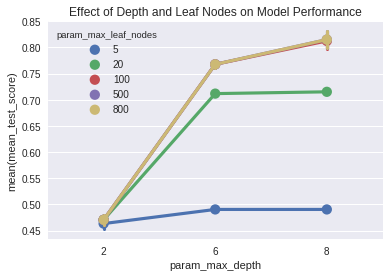

In [24]:
fig, ax = plt.subplots()

sns.pointplot(data=df[['mean_test_score',
                      'param_max_leaf_nodes',
                      'param_max_depth']],
              y='mean_test_score',
              x='param_max_depth',
              hue='param_max_leaf_nodes',
              ax=ax)

ax.set(title="Effect of Depth and Leaf Nodes on Model Performance")

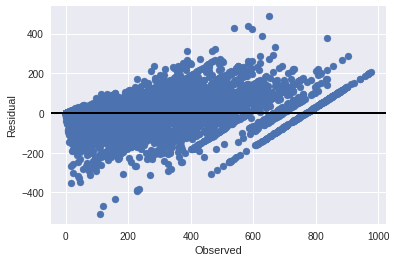

In [26]:
predicted = grid_cv_dtr.best_estimator_.predict(training_input_fn)
residuals = training_targets.flatten()-predicted

fig, ax = plt.subplots()
ax.scatter(training_targets.flatten(), residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

In [28]:
r2_scores = cross_val_score(grid_cv_dtr.best_estimator_, 
                            training_input_fn, 
                            training_targets, 
                            cv=10)

mse_scores = cross_val_score(grid_cv_dtr.best_estimator_, 
                             training_input_fn, 
                             training_targets, 
                             cv=10,
                             scoring='neg_mean_squared_error')

print("avg R-squared::{}".format(np.mean(r2_scores)))
print("MSE::{}".format(np.mean(mse_scores)))

avg R-squared::0.862333817351
MSE::-4499.22691796


In [0]:
'''
Testing the model
'''

In [0]:
best_dtr_model = grid_cv_dtr.best_estimator_

In [0]:
validation_encoded_category_features = []

for enc in training_encoded_category_features:
    col_name = enc['col_name']
    label_encoders = enc['label_enc']
    onehot_encoder = enc['ohe_enc']
    validation_encoded_category_features.append({'feature_df':create_predict_input_fn(validation_examples, 
                                                                                    col_name, 
                                                                                    label_encoders, 
                                                                                    onehot_encoder),
                                               'col_name':col_name})
    

In [33]:
validation_feature_df_list = [validation_examples[numeric_feature_cols]]
validation_feature_df_list.extend([enc['feature_df'] for enc in validation_encoded_category_features])

predict_validation_input_fn = pd.concat(validation_feature_df_list, axis=1)
validation_targets = validation_targets.total_count.values.reshape(-1,1)

print("Shape::{}".format(predict_validation_input_fn.shape))

Shape::(5909, 19)


In [34]:
predictions = best_dtr_model.predict(predict_validation_input_fn)
residuals = validation_targets.flatten() - predictions

r2_score = best_dtr_model.score(predict_validation_input_fn, validation_targets)
print("R-squared::{}".format(r2_score))
print("MSE: %.2f"
      % metrics.mean_squared_error(validation_targets, predictions))

R-squared::0.870159244709
MSE: 4311.38


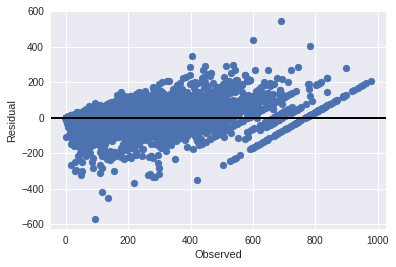

In [35]:
fig, ax = plt.subplots()
ax.scatter(validation_targets.flatten(), residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

r2_score = grid_cv_dtr.best_estimator_.score(predict_validation_input_fn, validation_targets)